In [1]:
import numpy as np
import time
import pandas as pd
import time
import sys, os
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import miceforest as mf

d = 4
alpha = 1
betas = np.ones(d)
gammas = np.ones(d)

%run 'all_imputations.ipynb'
%run 'all_classifiers.ipynb'

In [2]:
df = pd.read_csv("mammographic_masses.data", sep=",") 

df = df.replace('?',np.nan).astype(float)
df = df.astype(float)
print(df)

df_npy = df.to_numpy()
print(df_npy)

     BI-RADS   Age  Shape  Margin  Density  Severity
0        5.0  67.0    3.0     5.0      3.0       1.0
1        4.0  43.0    1.0     1.0      NaN       1.0
2        5.0  58.0    4.0     5.0      3.0       1.0
3        4.0  28.0    1.0     1.0      3.0       0.0
4        5.0  74.0    1.0     5.0      NaN       1.0
..       ...   ...    ...     ...      ...       ...
956      4.0  47.0    2.0     1.0      3.0       0.0
957      4.0  56.0    4.0     5.0      3.0       1.0
958      4.0  64.0    4.0     5.0      3.0       0.0
959      5.0  66.0    4.0     5.0      3.0       1.0
960      4.0  62.0    3.0     3.0      3.0       0.0

[961 rows x 6 columns]
[[ 5. 67.  3.  5.  3.  1.]
 [ 4. 43.  1.  1. nan  1.]
 [ 5. 58.  4.  5.  3.  1.]
 ...
 [ 4. 64.  4.  5.  3.  0.]
 [ 5. 66.  4.  5.  3.  1.]
 [ 4. 62.  3.  3.  3.  0.]]


In [3]:
# drop categorical categories
df_new = df.drop(columns=['BI-RADS'])

print('\nNumber of missing values: \n', df_new.isna().sum(), '\n')
df_npy = df_new.to_numpy()

# Initialise all_data matrix that we will use
N_all = df_npy.shape[0] 
all_data = np.zeros((N_all,d+1))
all_data[:,0:d] = df_npy[:,0:d]
all_data[:,d] = df_npy[:,d]

print('N_all = ', N_all)


Number of missing values: 
 Age          5
Shape       31
Margin      48
Density     76
Severity     0
dtype: int64 

N_all =  961


In [4]:
X_all = np.zeros((N_all,d))
Y_all = np.zeros(N_all)

all_data = np.random.permutation(all_data)

X_all = all_data[:,0:d]
Y_all = all_data[:,d]
O_all = np.ones((N_all,d))

# Create matrix with observation patterns
for i in range(N_all):
    for j in range(d):
        if np.isnan(X_all[i,j]):
            O_all[i,j] = 0
            
# Split all data into a training and test set
N_test = 161
N_train = N_all - N_test
x_test = np.zeros((N_test,d))
X_train =  np.zeros((N_train,d))
O_train =  np.zeros((N_train,d))
y_test = np.zeros(N_test)
Y_train = np.zeros(N_train)
j=0
l=0
for i in range(N_all):
    if (O_all[i,:]==np.ones(d)).all() and j<N_test:
        x_test[j,:] = X_all[i,:]
        y_test[j] = Y_all[i]
        j+=1
    else:
        X_train[l,:] = X_all[i,:]
        O_train[l,:] = O_all[i,:]
        Y_train[l] = Y_all[i]
        l+=1
        
        
counts_CC_C1=0
counts_NCC_C1=0
counts_CC_C0=0
counts_NCC_C0=0
for i in range(N_all):
    if np.sum(O_all[i,:])==d and Y_all[i]==1:
        counts_CC_C1+=1
    elif np.sum(O_all[i,:])==d and Y_all[i]==0:
        counts_CC_C0+=1
    elif np.sum(O_all[i,:])<d and Y_all[i]==1:
        counts_NCC_C1+=1
    elif np.sum(O_all[i,:])<d and Y_all[i]==0:
        counts_NCC_C0+=1
print('Proportion of points with label 1 in CC:',np.round(counts_CC_C1/(counts_CC_C1+counts_CC_C0),3))
print('Proportion of points with label 1 in notCC:',np.round(counts_NCC_C1/(counts_NCC_C1+counts_NCC_C0),3))



print('Proportion of points with label 1 in total:',np.round(np.sum(all_data[:,d])/N_all,3))
print('Points with label 1 in total:',np.round(np.sum(all_data[:,d]),3))
print('Points with label 0 in total:',np.round(N_all-np.sum(all_data[:,d]),3))

Proportion of points with label 1 in CC: 0.485
Proportion of points with label 1 in notCC: 0.323
Proportion of points with label 1 in total: 0.463
Points with label 1 in total: 445.0
Points with label 0 in total: 516.0


In [5]:
# Complete Case kNN
start = time.time()
accuracy_cc_kNN = 0
for i in range(N_test):
    if y_test[i] == complete_case_kNN_classifier(x_test[i,:],X_train,Y_train,O_train):
        accuracy_cc_kNN += 1/N_test
end = time.time()
run_time_cc_kNN = end-start
print('Runtime Complete Case kNN (in s): ',np.round(run_time_cc_kNN,3))
print('    Accuracy: ',np.round(accuracy_cc_kNN,3))

# Mean Imputation then kNN
start = time.time()
X_imputed = mean_impute(X_train, O_train)
accuracy_mi_kNN = 0
for i in range(N_test):
    if y_test[i] == complete_case_kNN_classifier(x_test[i,:],X_imputed,Y_train,np.ones((N_train,d))):
        accuracy_mi_kNN += 1/N_test
end = time.time()
run_time_mi_kNN = end-start
print('Runtime Mean Imputation and kNN (in s): ',np.round(run_time_mi_kNN,3))
print('    Accuracy: ',np.round(accuracy_mi_kNN,3))

# c=0 Imputation then kNN
start = time.time()
X_imputed = constant_impute(X_train, O_train)
accuracy_ci_kNN = 0
for i in range(N_test):
    if y_test[i] == complete_case_kNN_classifier(x_test[i,:],X_imputed,Y_train,np.ones((N_train,d))):
        accuracy_ci_kNN += 1/N_test
end = time.time()
run_time_ci_kNN = end-start
print('Runtime Constant Imputation and kNN (in s): ',np.round(run_time_ci_kNN,3))
print('    Accuracy: ',np.round(accuracy_ci_kNN,3))

# MissForest then kNN
imputer = MissForest(criterion=('squared_error', 'gini'),max_features=1.0)
X_miss = np.zeros((N_train,d))
X_miss += X_train
for i in range(N_train):
    for j in range(d):
        if O_train[i,j]==0:
            X_miss[i,j] = 'nan'
sys.stdout = open(os.devnull, 'w')
X_imputed = imputer.fit_transform(X_miss)
sys.stdout = sys.__stdout__
accuracy_mf_kNN = 0
for i in range(N_test):
    if y_test[i] == complete_case_kNN_classifier(x_test[i,:],X_imputed,Y_train,np.ones((N_train,d))):
        accuracy_mf_kNN += 1/N_test
end = time.time()
run_time_mf_kNN = end-start
print('Runtime MissForest and kNN (in s): ',np.round(run_time_mf_kNN,3))
print('    Accuracy: ',np.round(accuracy_mf_kNN,3))

# HAM
start = time.time()
Omega_hat = []
Omega_hat = estimate_Omega_star(X_train, Y_train, O_train, alpha, betas, gammas)
accuracy_HAM = 0
for i in range(N_test):
    if y_test[i] == HAM_classifier(x_test[i,:], Omega_hat, X_train, Y_train, O_train, alpha, betas, gammas):
        accuracy_HAM += 1/N_test
end = time.time()
run_time_HAM = end-start
print('Runtime HAM (in s): ',np.round(run_time_HAM,3))
print('    Accuracy: ',np.round(accuracy_HAM,3))

# cvHAM
start = time.time()
Omega_hat = []
r_optimal = estimate_params_CV(X_train, Y_train, O_train)
Omega_hat = estimate_Omega_star(X_train, Y_train, O_train, r_optimal[0],r_optimal[1],r_optimal[2])
print('alpha = ',r_optimal[0])
print('betas = ',r_optimal[1])
print('gammas = ',r_optimal[2])
accuracy_cvHAM = 0
for i in range(N_test):
    if y_test[i] == HAM_classifier(x_test[i,:], Omega_hat, X_train, Y_train, O_train, r_optimal[0],r_optimal[1],r_optimal[2]):
        accuracy_cvHAM += 1/N_test
end = time.time()
run_time_cvHAM = end-start
print('Runtime cvHAM (in s): ',np.round(run_time_cvHAM,3))
print('    Accuracy: ',np.round(accuracy_cvHAM,3))

# Random Forest Imputation + kNN - Fit on and transform our training data; Only use 2 iterations of mice.
start = time.time()
X_miss = np.zeros((N_train,d))
X_miss += X_train
for i in range(N_train):
    for j in range(d):
        if O_train[i,j]==0:
            X_miss[i,j] = 'nan'
# Run the MICE algorithm for 2 iterations and return 5 completed datasets
kds = mf.ImputationKernel(X_miss, datasets=5)
kds.mice(2)
accuracy_mice_kNN = 0
for i in range(N_test):
    y_s=0
    for s in range(5):
        X_train_t = kds.complete_data(dataset=s)
        y_s += complete_case_kNN_classifier(x_test[i,:],X_train_t,Y_train,np.ones((N_train,d)))/5
    if y_s>=1/2:
        y_s = 1
    else:
        y_s = 0
    if y_test[i] == y_s:
        accuracy_mice_kNN += 1/N_test
end = time.time()
run_time_mice_kNN = end-start
print('Runtime mice and kNN (in s): ',np.round(run_time_mice_kNN,3))
print('    Accuracy: ',np.round(accuracy_mice_kNN,3))


iterations = 100
print('\nEstimated runtime (in min): ',np.round(iterations*(run_time_mice_kNN+run_time_ci_kNN+run_time_mf_kNN+run_time_cc_kNN+run_time_mi_kNN+run_time_HAM+run_time_cvHAM)/60,3))

Runtime Complete Case kNN (in s):  0.457
    Accuracy:  0.702
Runtime Mean Imputation and kNN (in s):  0.487
    Accuracy:  0.696
Runtime Constant Imputation and kNN (in s):  0.491
    Accuracy:  0.714
Runtime MissForest and kNN (in s):  2.287
    Accuracy:  0.689
Runtime HAM (in s):  29.431
    Accuracy:  0.758
alpha =  0
betas =  [0.25 0.25 0.25 0.25]
gammas =  [0.5 0.5 0.5 0.5]
Runtime cvHAM (in s):  1729.109
    Accuracy:  0.714
Runtime mice and kNN (in s):  11.102
    Accuracy:  0.689

Estimated runtime (in min):  2955.607


Test Accuracy Complete Case kNN:  0.7315


Test Accuracy Complete Case kNN:  0.7315
Test Accuracy Mean Imputation then kNN  :  0.732
Test Accuracy c=0 Imputation then kNN:  0.7322
Test Accuracy Random Forest Imputation then kNN:  0.7465
Test Accuracy MissForest then kNN:  0.7337
Test Accuracy HAM:  0.7827
Test Accuracy cvHAM:  0.7754


In [6]:
np.random.seed(2023)

accuracy_cc_kNN = np.zeros(iterations)
accuracy_mi_kNN = np.zeros(iterations)
accuracy_ci_kNN = np.zeros(iterations)
accuracy_mf_kNN = np.zeros(iterations)
accuracy_HAM = np.zeros(iterations)
accuracy_cvHAM = np.zeros(iterations)
accuracy_mice_kNN = np.zeros(iterations)

for it in range(iterations):
    # Permute rows randomly to ensure there is no bias in the order of the rows, ensures fair train/test split later
    all_data = np.random.permutation(all_data)

    X_all = all_data[:,0:d]
    Y_all = all_data[:,d]
    O_all = np.ones((N_all,d))

    # Create matrix with observation patterns
    for i in range(N_all):
        for j in range(d):
            if np.isnan(X_all[i,j]):
                O_all[i,j] = 0

    # Split all data into a training and test set
    x_test = np.zeros((N_test,d))
    X_train =  np.zeros((N_train,d))
    O_train =  np.zeros((N_train,d))
    y_test = np.zeros(N_test)
    Y_train = np.zeros(N_train)
    j=0
    l=0
    for i in range(N_all):
        if (O_all[i,:]==np.ones(d)).all() and j<N_test:
            x_test[j,:] = X_all[i,:]
            y_test[j] = Y_all[i]
            j+=1
        else:
            X_train[l,:] = X_all[i,:]
            O_train[l,:] = O_all[i,:]
            Y_train[l] = Y_all[i]
            l+=1
            
    # Complete Case kNN
    for i in range(N_test):
        if y_test[i] == complete_case_kNN_classifier(x_test[i,:],X_train,Y_train,O_train):
            accuracy_cc_kNN[it] += 1/N_test

    if not (O_train==np.ones((N_train,d))).all():        
        # Mean Imputation then kNN  
        X_imputed = mean_impute(X_train, O_train)
        for i in range(N_test):
            if y_test[i] == complete_case_kNN_classifier(x_test[i,:],X_imputed,Y_train,np.ones((N_train,d))):
                accuracy_mi_kNN[it] += 1/N_test

        # c=0 Imputation then kNN
        X_imputed = constant_impute(X_train, O_train)
        for i in range(N_test):
            if y_test[i] == complete_case_kNN_classifier(x_test[i,:],X_imputed,Y_train,np.ones((N_train,d))):
                accuracy_ci_kNN[it] += 1/N_test

        # MissForest imputation using missingpy
        X_miss = np.zeros((N_train,d))
        X_miss += X_train
        for i in range(N_train):
            for j in range(d):
                if O_train[i,j]==0:
                    X_miss[i,j] = 'nan'
        sys.stdout = open(os.devnull, 'w')
        X_imputed = imputer.fit_transform(X_miss)
        sys.stdout = sys.__stdout__
        for i in range(N_test):
            if y_test[i] == complete_case_kNN_classifier(x_test[i,:],X_imputed,Y_train,np.ones((N_train,d))):
                accuracy_mf_kNN[it] += 1/N_test

    # HAM
    Omega_hat = []
    Omega_hat = estimate_Omega_star(X_train, Y_train, O_train, alpha, betas, gammas)
    for i in range(N_test):
        if y_test[i] == HAM_classifier(x_test[i,:], Omega_hat, X_train, Y_train, O_train, alpha, betas, gammas):
            accuracy_HAM[it] += 1/N_test        

    # cvHAM
    Omega_hat = []
    r_optimal = estimate_params_CV(X_train, Y_train, O_train)
    Omega_hat = estimate_Omega_star(X_train, Y_train, O_train, r_optimal[0],r_optimal[1],r_optimal[2])
    for i in range(N_test):
        if y_test[i] == HAM_classifier(x_test[i,:], Omega_hat, X_train, Y_train, O_train, r_optimal[0],r_optimal[1],r_optimal[2]):
            accuracy_cvHAM[it] += 1/N_test     

    if not (O_train==np.ones((N_train,d))).all():
        # Random Forest Imputation + kNN
        X_miss = np.zeros((N_train,d))
        X_miss += X_train
        for i in range(N_train):
            for j in range(d):
                if O_train[i,j]==0:
                    X_miss[i,j] = 'nan'
        # Run the MICE algorithm for 2 iterations and return 5 completed datasets
        kds = mf.ImputationKernel(X_miss, datasets=5)
        kds.mice(2)
        for i in range(N_test):
            y_s=0
            for s in range(5):
                X_train_t = kds.complete_data(dataset=s)
                y_s += complete_case_kNN_classifier(x_test[i,:],X_train_t,Y_train,np.ones((N_train,d)))/5
            if y_s>=1/2:
                y_s = 1
            else:
                y_s = 0
            if y_test[i] == y_s:
                accuracy_mice_kNN[it] += 1/N_test

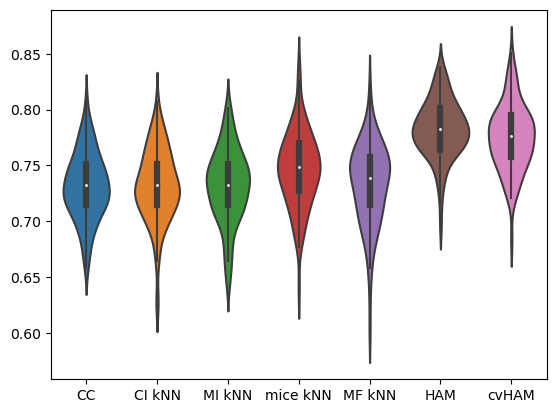

In [8]:
print('\n\nTest Accuracy Complete Case kNN: ',np.round(np.sum(accuracy_cc_kNN)/iterations,4))
print('Test Accuracy Mean Imputation then kNN  : ',np.round(np.sum(accuracy_mi_kNN)/iterations,4))
print('Test Accuracy c=0 Imputation then kNN: ',np.round(np.sum(accuracy_ci_kNN)/iterations,4))
print('Test Accuracy Random Forest Imputation then kNN: ',np.round(np.sum(accuracy_mice_kNN)/iterations,4))
print('Test Accuracy MissForest then kNN: ',np.round(np.sum(accuracy_mf_kNN)/iterations,4))
print('Test Accuracy HAM: ',np.round(np.sum(accuracy_HAM)/iterations,4))
print('Test Accuracy cvHAM: ',np.round(np.sum(accuracy_cvHAM)/iterations,4))

summary_accuracies = [accuracy_cc_kNN,accuracy_ci_kNN,accuracy_mi_kNN,accuracy_mice_kNN,accuracy_mf_kNN,accuracy_HAM,accuracy_cvHAM]
summary_plot = sns.violinplot(summary_accuracies)

summary_plot.set_xticklabels(['CC','CI kNN','MI kNN','mice kNN','MF kNN','HAM','cvHAM'])

plt.show(summary_plot)

In [9]:
''' Save accuracies for further use '''

np.save('Ex4_accuracy_cc_kNN',accuracy_cc_kNN)
np.save('Ex4_accuracy_mi_kNN',accuracy_mi_kNN)
np.save('Ex4_accuracy_ci_kNN',accuracy_ci_kNN)
np.save('Ex4_accuracy_mf_kNN',accuracy_mf_kNN)
np.save('Ex4_accuracy_mice_kNN',accuracy_mice_kNN)
np.save('Ex4_accuracy_HAM',accuracy_HAM)
np.save('Ex4_accuracy_cvHAM',accuracy_cvHAM)